In [1]:
# ============================================================
# 0. Montar Drive e imports
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

import os, json, random, time
import numpy as np
import cv2
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models import resnet50

import pandas as pd
from IPython.display import display


Mounted at /content/drive


In [2]:
# ============================================================
# 1. Paths y configuración general
# ============================================================
ROOT = "/content/drive/MyDrive/proyecto_escoliosis_MAIA"
IMG_DIR = os.path.join(ROOT, "Radiografías")
COCO_JSON = os.path.join(ROOT, "Anotaciones vértebras/coco_anotaciones_actualizadas_23sep.json")
MODELS_DIR = os.path.join(ROOT, "models_dense_decoder")
os.makedirs(MODELS_DIR, exist_ok=True)

# Tamaño de entrada (para el decoder 32->64->128->256)
IMG_SIZE = 256
NUM_CLASSES = 3   # F, V, T1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
# ============================================================
# 2. Cargar COCO y filtrar solo imágenes existentes
# ============================================================
with open(COCO_JSON, "r") as f:
    coco_raw = json.load(f)

print("Imágenes en COCO:", len(coco_raw["images"]))
print("Anotaciones en COCO:", len(coco_raw["annotations"]))

# Mapeo de clases
id2label = {0: "F", 1: "V", 2: "T1"}
label2id = {v: k for k, v in id2label.items()}

def filter_coco_existing(coco, img_root):
    existing = set(os.listdir(img_root))
    images_f = []
    valid_ids = set()

    for img in coco["images"]:
        fname = img.get("toras_path", img.get("file_name", "")).lstrip("/")
        base = os.path.basename(fname)
        if base in existing:
            images_f.append(img)
            valid_ids.add(img["id"])

    anns_f = [a for a in coco["annotations"] if a["image_id"] in valid_ids]

    coco_f = {
        "images": images_f,
        "annotations": anns_f,
        "categories": coco.get("categories", []),
    }
    print("Imágenes filtradas:", len(images_f))
    print("Anotaciones filtradas:", len(anns_f))
    return coco_f

coco = filter_coco_existing(coco_raw, IMG_DIR)


Imágenes en COCO: 184
Anotaciones en COCO: 564
Imágenes filtradas: 174
Anotaciones filtradas: 499


In [4]:
# ============================================================
# 3. Dataset Spine + T1 (resize 256x256, augment simple)
# ============================================================
def resize_img_mask(img_rgb, mask, size=256):
    img_resized = cv2.resize(img_rgb, (size, size), interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    return img_resized, mask_resized

def random_flip(img_rgb, mask):
    if random.random() < 0.5:
        img_rgb = np.ascontiguousarray(img_rgb[:, ::-1, :])
        mask    = np.ascontiguousarray(mask[:, ::-1])
    return img_rgb, mask

class SpineT1Dataset(Dataset):
    def __init__(self, coco, img_root, image_ids, train=True):
        self.coco = coco
        self.img_root = img_root
        self.image_ids = image_ids
        self.train = train

        self.imgid2info = {img["id"]: img for img in coco["images"]}
        self.anns_by_img = defaultdict(list)
        for a in coco["annotations"]:
            self.anns_by_img[a["image_id"]].append(a)

    def __len__(self):
        return len(self.image_ids)

    def _build_mask(self, img_id, h, w):
        mask = np.zeros((h, w), dtype=np.uint8)
        anns = self.anns_by_img.get(img_id, [])
        for ann in anns:
            name = ann.get("name")
            if name not in label2id:
                continue
            cls_id = label2id[name]
            seg = ann.get("segmentation", [])
            if not seg:
                continue

            # ignorar RLE para simplificar
            if isinstance(seg, dict):
                continue

            if isinstance(seg[0], (int, float)):
                seg = [seg]

            for poly in seg:
                if not poly or len(poly) < 6:
                    continue
                pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
                if pts.shape[0] < 3:
                    continue
                pts = pts.astype(np.int32)
                try:
                    cv2.fillPoly(mask, [pts], cls_id)
                except cv2.error:
                    continue
        return mask

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        info = self.imgid2info[img_id]

        fname = info.get("toras_path", info.get("file_name", "")).lstrip("/")
        img_path = os.path.join(self.img_root, os.path.basename(fname))

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"No se pudo leer {img_path}")

        h, w = img.shape[:2]
        mask = self._build_mask(img_id, h, w)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        img_rgb, mask = resize_img_mask(img_rgb, mask, size=IMG_SIZE)

        if self.train:
            img_rgb, mask = random_flip(img_rgb, mask)

        img_rgb = img_rgb.astype(np.float32) / 255.0
        img_rgb = np.transpose(img_rgb, (2, 0, 1))
        mask = mask.astype(np.int64)

        return torch.from_numpy(img_rgb), torch.from_numpy(mask)


In [5]:
# ============================================================
# 4. Split train / val + DataLoaders
# ============================================================
all_ids = [img["id"] for img in coco["images"]]
random.seed(42)
random.shuffle(all_ids)

split = int(0.8 * len(all_ids))
train_ids = all_ids[:split]
val_ids   = all_ids[split:]

train_ds = SpineT1Dataset(coco, IMG_DIR, train_ids, train=True)
val_ds   = SpineT1Dataset(coco, IMG_DIR, val_ids,   train=False)

BATCH_SIZE = 4

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, drop_last=False)

len(train_ds), len(val_ds)


(139, 35)

In [6]:
# ============================================================
# 5. Pérdida y métricas (IoU, Dice)
# ============================================================
def dice_loss(logits, targets, num_classes, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    targets_onehot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

    dims = (0, 2, 3)
    intersection = torch.sum(probs * targets_onehot, dims)
    cardinality  = torch.sum(probs + targets_onehot, dims)
    dice = (2.0 * intersection + eps) / (cardinality + eps)

    dice_fg = dice[1:]
    return 1.0 - dice_fg.mean()

class CombinedLoss(nn.Module):
    def __init__(self, num_classes, ce_w=0.6, dice_w=0.4, class_weights=None):
        super().__init__()
        self.ce_w = ce_w
        self.dice_w = dice_w
        self.ce = nn.CrossEntropyLoss(weight=class_weights)
        self.num_classes = num_classes

    def forward(self, logits, targets):
        ce = self.ce(logits, targets)
        d  = dice_loss(logits, targets, self.num_classes)
        return self.ce_w * ce + self.dice_w * d

def update_iou_stats(stats, preds, targets, num_classes):
    # preds, targets: (B,H,W)
    for c in range(num_classes):
        pred_c = (preds == c)
        target_c = (targets == c)
        inter = (pred_c & target_c).sum().item()
        union = (pred_c | target_c).sum().item()
        stats["inter"][c] += inter
        stats["union"][c] += union

def compute_iou_from_stats(stats):
    inter = np.array(stats["inter"], dtype=np.float64)
    union = np.array(stats["union"], dtype=np.float64)
    iou = np.zeros_like(inter, dtype=np.float64)
    valid = union > 0
    iou[valid] = inter[valid] / union[valid]
    iou[~valid] = np.nan
    return iou


In [7]:
# ============================================================
# 6. Módulos del modelo: ASPP, Attention Gates, Decoder denso
# ============================================================
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels=256, rates=(6, 12, 18)):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=rates[0],
                      dilation=rates[0], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=rates[1],
                      dilation=rates[1], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=rates[2],
                      dilation=rates[2], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.project = nn.Sequential(
            nn.Conv2d(out_channels * 5, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )

    def forward(self, x):
        h, w = x.shape[2:]
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.image_pool(x)
        x5 = F.interpolate(x5, size=(h, w), mode="bilinear", align_corners=False)
        x_cat = torch.cat([x1, x2, x3, x4, x5], dim=1)
        return self.project(x_cat)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.Wg = nn.Sequential(
            nn.Conv2d(F_g, F_int, 1, bias=True),
            nn.BatchNorm2d(F_int),
        )
        self.Wx = nn.Sequential(
            nn.Conv2d(F_l, F_int, 1, bias=True),
            nn.BatchNorm2d(F_int),
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, 1, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g: gating (decoder), x: skip (encoder)
        g1 = self.Wg(g)
        x1 = self.Wx(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DenseDecoderBlock(nn.Module):
    """
    Bloque de decoder "denso":
    - upsample del feature de entrada
    - atención sobre skip (si hay)
    - concatena: upsample actual + upsample de features previos + skip atendido
    """
    def __init__(self, in_ch, skip_ch, prev_ch, out_ch, use_attention=True):
        super().__init__()
        self.use_attention = use_attention and skip_ch > 0
        if self.use_attention:
            self.att = AttentionGate(F_g=in_ch, F_l=skip_ch, F_int=out_ch)

        # conv para fusionar (in_ch + prev_ch + skip_ch) -> out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch + prev_ch + (skip_ch if self.use_attention else 0),
                      out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip=None, prev_upsampled=None, scale_factor=2):
        x_up = F.interpolate(x, scale_factor=scale_factor, mode="bilinear",
                             align_corners=False)

        feats = [x_up]

        if prev_upsampled is not None:
            feats.append(prev_upsampled)

        if self.use_attention and skip is not None:
            # redimensionar skip al tamaño de x_up por si acaso
            if skip.shape[2:] != x_up.shape[2:]:
                skip = F.interpolate(skip, size=x_up.shape[2:], mode="bilinear",
                                     align_corners=False)
            skip_att = self.att(x_up, skip)
            feats.append(skip_att)

        x_cat = torch.cat(feats, dim=1)
        out = self.conv(x_cat)
        return out


In [8]:
# ============================================================
# 7. Modelo: DeepLabV3+ encoder + decoder denso 4 niveles
# ============================================================
class DeepLabV3PlusDenseDecoder(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        # ResNet50 backbone (como DeepLab, con dilataciones)
        self.backbone = resnet50(weights=None,
                                 replace_stride_with_dilation=[False, True, True])

        # Tomamos features en varios niveles
        self.layer0 = nn.Sequential(
            self.backbone.conv1,
            self.backbone.bn1,
            self.backbone.relu,
        )  # ~128x128 para input 256
        self.maxpool = self.backbone.maxpool          # 64x64
        self.layer1 = self.backbone.layer1            # 64x64
        self.layer2 = self.backbone.layer2            # 32x32
        self.layer3 = self.backbone.layer3            # 32x32 (dilatado)
        self.layer4 = self.backbone.layer4            # 32x32 (dilatado)

        # ASPP sobre layer4
        self.aspp = ASPP(in_channels=2048, out_channels=256)

        # Proyección de skips
        self.enc_32 = nn.Conv2d(1024, 256, 1)   # de layer3 (32x32)
        self.enc_64 = nn.Conv2d(256, 128, 1)    # de layer1 (64x64)
        self.enc_128 = nn.Conv2d(64, 64, 1)     # de layer0 (128x128)

        # Decoder denso (4 niveles)
        # Nivel 0: 32x32 (no upsample todavía, solo conv)
        self.dec0_conv = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Nivel 1: 32 -> 64, con skip de 64x64
        self.dec1 = DenseDecoderBlock(
            in_ch=256,   # viene de dec0
            skip_ch=128, # enc_64
            prev_ch=0,
            out_ch=128,
            use_attention=True,
        )

        # Nivel 2: 64 -> 128, con skip de 128x128 y conexiones densas
        self.dec2 = DenseDecoderBlock(
            in_ch=128,
            skip_ch=64,   # enc_128
            prev_ch=256,  # upsample de dec0
            out_ch=64,
            use_attention=True,
        )

        # Nivel 3: 128 -> 256, sin skip (solo dense de prev)
        self.dec3 = DenseDecoderBlock(
            in_ch=64,
            skip_ch=0,      # sin skip extra
            prev_ch=128+256, # upsample de dec1 y dec0
            out_ch=64,
            use_attention=False,
        )

        # Clasificador final
        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x0 = self.layer0(x)            # 128x128
        x0p = self.maxpool(x0)         # 64x64
        x1 = self.layer1(x0p)          # 64x64
        x2 = self.layer2(x1)           # 32x32
        x3 = self.layer3(x2)           # 32x32
        x4 = self.layer4(x3)           # 32x32

        # ASPP
        x_aspp = self.aspp(x4)         # 32x32

        # Skips proyectados
        enc32 = self.enc_32(x3)        # 256 canales, 32x32 (por si quieres usarlo más adelante)
        enc64 = self.enc_64(x1)        # 128 canales, 64x64
        enc128 = self.enc_128(x0)      # 64 canales, 128x128

        # Decoder nivel 0 (32x32)
        d0 = self.dec0_conv(x_aspp)    # 256, 32x32

        # Decoder nivel 1 (32 -> 64), con atención sobre enc64
        d1 = self.dec1(d0, skip=enc64, prev_upsampled=None, scale_factor=2)  # 128, 64x64

        # Decoder nivel 2 (64 -> 128), denso: usa d1 y d0 upsamplados + skip enc128
        d0_up_128 = F.interpolate(d0, scale_factor=4, mode="bilinear", align_corners=False)  # 256, 128x128
        d2 = self.dec2(d1, skip=enc128, prev_upsampled=d0_up_128, scale_factor=2)           # 64, 128x128

        # Decoder nivel 3 (128 -> 256), denso: concat de d2 + d1_up + d0_up
        d1_up_256 = F.interpolate(d1, scale_factor=4, mode="bilinear", align_corners=False) # 128, 256x256
        d0_up_256 = F.interpolate(d0, scale_factor=8, mode="bilinear", align_corners=False) # 256, 256x256

        # Para el bloque dec3, pasamos una "prev_upsampled" que concatena d1_up y d0_up
        prev_cat = torch.cat([d1_up_256, d0_up_256], dim=1)  # (128+256, 256x256)
        d3 = self.dec3(d2, skip=None, prev_upsampled=prev_cat, scale_factor=2)               # 64, 256x256

        logits = self.classifier(d3)   # (B, num_classes, 256,256)
        return logits

# Instanciar modelo
model = DeepLabV3PlusDenseDecoder(num_classes=NUM_CLASSES).to(device)
print("Parámetros totales (M):", sum(p.numel() for p in model.parameters())/1e6)

# Truco opcional: congelar BatchNorm2d en modo eval para evitar problemas con batch pequeño
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.eval()
        for p in m.parameters():
            p.requires_grad = False


Parámetros totales (M): 43.225585


In [9]:
# ============================================================
# 8. Entrenamiento con métricas (IoU clase, mIoU, Dice)
# ============================================================
class_weights = torch.tensor([0.05, 1.0, 3.0], dtype=torch.float32).to(device)
criterion = CombinedLoss(NUM_CLASSES, ce_w=0.6, dice_w=0.4, class_weights=class_weights)

LR = 3e-4
EPOCHS = 50

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

history = {
    "epoch": [],
    "val_iou_t1": [],
    "val_iou_v": [],
    "val_miou": [],
    "val_dice": [],
}

best_val_miou = 0.0
best_model_path = os.path.join(MODELS_DIR, "model_deeplab_dense_decoder.pth")
start_time = time.time()

for epoch in range(1, EPOCHS+1):

    # ----------------- TRAIN -----------------
    model.train()
    train_loss = 0.0
    train_stats = {"inter": [0]*NUM_CLASSES, "union": [0]*NUM_CLASSES}

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

        preds = torch.argmax(logits, dim=1)
        update_iou_stats(train_stats, preds.cpu(), masks.cpu(), NUM_CLASSES)

    train_loss /= len(train_loader.dataset)
    train_ious = compute_iou_from_stats(train_stats)
    train_miou = np.nanmean(train_ious[1:])

    # ----------------- VAL -----------------
    model.eval()
    val_loss = 0.0
    val_stats = {"inter": [0]*NUM_CLASSES, "union": [0]*NUM_CLASSES}
    val_dice_acc = 0.0
    val_samples = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = criterion(logits, masks)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.argmax(logits, dim=1)
            update_iou_stats(val_stats, preds.cpu(), masks.cpu(), NUM_CLASSES)

            batch_dice = 1.0 - dice_loss(logits, masks, NUM_CLASSES).item()
            val_dice_acc += batch_dice * imgs.size(0)
            val_samples  += imgs.size(0)

    val_loss /= len(val_loader.dataset)
    val_ious = compute_iou_from_stats(val_stats)
    val_miou = np.nanmean(val_ious[1:])
    val_dice = val_dice_acc / max(1, val_samples)

    iou_f  = val_ious[label2id["F"]]
    iou_v  = val_ious[label2id["V"]]
    iou_t1 = val_ious[label2id["T1"]]

    history["epoch"].append(epoch)
    history["val_iou_t1"].append(iou_t1)
    history["val_iou_v"].append(iou_v)
    history["val_miou"].append(val_miou)
    history["val_dice"].append(val_dice)

    scheduler.step()

    print(f"Epoch [{epoch}/{EPOCHS}] "
          f"TrainLoss: {train_loss:.4f}  ValLoss: {val_loss:.4f}  "
          f"Train mIoU(no F): {train_miou:.4f}  Val mIoU(no F): {val_miou:.4f}")
    print("  Val IoU por clase:")
    for cid, iou in enumerate(val_ious):
        print(f"    {cid} ({id2label[cid]}): {iou:.4f}")
    print(f"  Val Dice: {val_dice:.4f}")

    if val_miou > best_val_miou:
        best_val_miou = val_miou
        torch.save(model.state_dict(), best_model_path)
        print(f"  -> Nuevo mejor modelo guardado en {best_model_path}")

print("Entrenamiento terminado. Mejor mIoU val (sin fondo):", best_val_miou)
total_time_min = (time.time() - start_time) / 60.0
print(f"Tiempo total: {total_time_min:.2f} min")


Epoch [1/50] TrainLoss: 0.7302  ValLoss: 0.9168  Train mIoU(no F): 0.1028  Val mIoU(no F): 0.1080
  Val IoU por clase:
    0 (F): 0.7952
    1 (V): 0.1988
    2 (T1): 0.0173
  Val Dice: 0.1147
  -> Nuevo mejor modelo guardado en /content/drive/MyDrive/proyecto_escoliosis_MAIA/models_dense_decoder/model_deeplab_dense_decoder.pth
Epoch [2/50] TrainLoss: 0.6318  ValLoss: 0.6369  Train mIoU(no F): 0.1448  Val mIoU(no F): 0.1483
  Val IoU por clase:
    0 (F): 0.6609
    1 (V): 0.2755
    2 (T1): 0.0212
  Val Dice: 0.1914
  -> Nuevo mejor modelo guardado en /content/drive/MyDrive/proyecto_escoliosis_MAIA/models_dense_decoder/model_deeplab_dense_decoder.pth
Epoch [3/50] TrainLoss: 0.5915  ValLoss: 0.6401  Train mIoU(no F): 0.1624  Val mIoU(no F): 0.1737
  Val IoU por clase:
    0 (F): 0.7044
    1 (V): 0.2800
    2 (T1): 0.0674
  Val Dice: 0.2029
  -> Nuevo mejor modelo guardado en /content/drive/MyDrive/proyecto_escoliosis_MAIA/models_dense_decoder/model_deeplab_dense_decoder.pth
Epoch [4/5

In [10]:
# ============================================================
# 9. Tabla resumen del modelo
# ============================================================
best_idx = int(np.argmax(history["val_miou"]))

iou_t1_best = history["val_iou_t1"][best_idx]
iou_v_best  = history["val_iou_v"][best_idx]
miou_best   = history["val_miou"][best_idx]
dice_best   = history["val_dice"][best_idx]
epoch_best  = history["epoch"][best_idx]

num_params_m  = sum(p.numel() for p in model.parameters()) / 1e6
model_size_mb = os.path.getsize(best_model_path) / (1024**2)

row = {
    "Modelo": "DeepLabV3+ ResNet50 + Decoder Denso",
    "IoU T1": round(iou_t1_best, 4),
    "IoU V": round(iou_v_best, 4),
    "IoU Promedio": round(miou_best, 4),
    "Dice Score": round(dice_best, 4),
    "Parámetros (M)": round(num_params_m, 2),
    "Tamaño (MB)": round(model_size_mb, 2),
    "Época óptima": int(epoch_best),
    "Tiempo (min)": round(total_time_min, 2),
}

df = pd.DataFrame([row])
display(df)
print(df.to_markdown(index=False))


,Modelo,IoU T1,IoU V,IoU Promedio,Dice Score,Parámetros (M),Tamaño (MB),Época óptima,Tiempo (min)
0,DeepLabV3+ ResNet50 + Decoder Denso,0.4832,0.6691,0.5762,0.6823,43.23,165.31,43,18.22


| Modelo                              |   IoU T1 |   IoU V |   IoU Promedio |   Dice Score |   Parámetros (M) |   Tamaño (MB) |   Época óptima |   Tiempo (min) |
|:------------------------------------|---------:|--------:|---------------:|-------------:|-----------------:|--------------:|---------------:|---------------:|
| DeepLabV3+ ResNet50 + Decoder Denso |   0.4832 |  0.6691 |         0.5762 |       0.6823 |            43.23 |        165.31 |             43 |          18.22 |


Mostrando ejemplo idx=3


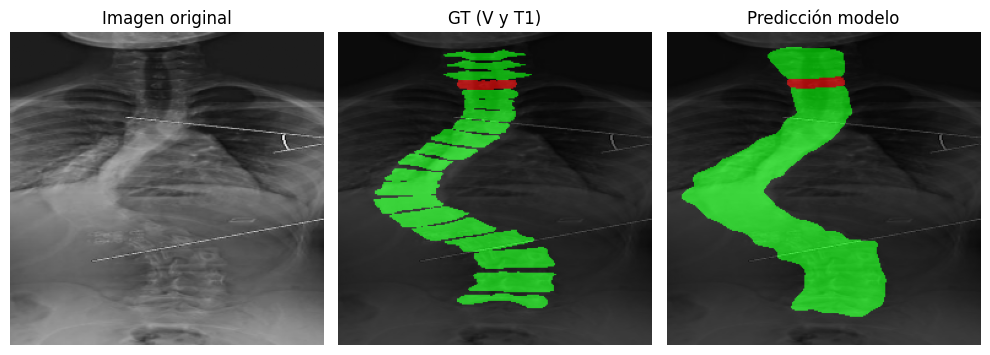

In [11]:
# ============================================================
# Inferencia de muestra y visualización de la segmentación
# ============================================================
import matplotlib.pyplot as plt

def load_best_dense_model():
    """Carga el mejor modelo entrenado desde best_model_path."""
    model_inf = DeepLabV3PlusDenseDecoder(num_classes=NUM_CLASSES).to(device)
    state_dict = torch.load(best_model_path, map_location=device)
    model_inf.load_state_dict(state_dict)
    model_inf.eval()
    # Mantener BatchNorm en eval (por si se cambió en entrenamiento)
    for m in model_inf.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
    return model_inf

def create_color_overlay(img_tensor, mask_tensor, alpha=0.6):
    """
    img_tensor: (3,H,W) en [0,1]
    mask_tensor: (H,W) con valores {0,1,2}
    """
    img = img_tensor.numpy().transpose(1, 2, 0)  # H,W,3
    mask = mask_tensor.numpy()

    # Colores por clase en RGB (0-1)
    colors = {
        0: (0.0, 0.0, 0.0),   # Fondo: negro (no se nota)
        1: (0.0, 1.0, 0.0),   # V (columna): verde
        2: (1.0, 0.0, 0.0),   # T1: rojo
    }

    color_mask = np.zeros_like(img)
    for cid, color in colors.items():
        color_mask[mask == cid] = color

    overlay = (1 - alpha) * img + alpha * color_mask
    overlay = np.clip(overlay, 0, 1)
    return overlay

def show_sample_prediction(idx=None, dataset=val_ds):
    """
    Muestra una imagen de 'dataset' con:
      - Imagen original
      - Máscara GT
      - Predicción del modelo
    """
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    img_t, mask_gt = dataset[idx]  # img_t: (3,H,W) float32, mask_gt: (H,W) long
    print(f"Mostrando ejemplo idx={idx}")

    model_inf = load_best_dense_model()

    with torch.no_grad():
        logits = model_inf(img_t.unsqueeze(0).to(device))  # (1,C,H,W)
        pred_mask = torch.argmax(logits, dim=1).squeeze(0).cpu()

    # Overlays
    overlay_gt   = create_color_overlay(img_t, mask_gt)
    overlay_pred = create_color_overlay(img_t, pred_mask)

    # Visualización
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_t.numpy().transpose(1, 2, 0), cmap="gray")
    plt.title("Imagen original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay_gt)
    plt.title("GT (V y T1)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_pred)
    plt.title("Predicción modelo")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Llamar a la función para ver un ejemplo aleatorio:
show_sample_prediction()
# Si quieres un índice específico:
# show_sample_prediction(idx=5)


In [12]:
# ============================================================
# Guardar y descargar JSON con información de clases del modelo
# ============================================================
import json

classes_info = {
    "model_name": "DeepLabV3PlusDenseDecoder",
    "id2label": {str(k): v for k, v in id2label.items()},
    "label2id": label2id,
    "num_classes": NUM_CLASSES,
    "img_size": [IMG_SIZE, IMG_SIZE],
    "notes": "0=Fondo, 1=Columna (V), 2=Vértebra T1",
}

classes_json_path = os.path.join(
    MODELS_DIR, "deeplab_dense_decoder_classes.json"
)

with open(classes_json_path, "w", encoding="utf-8") as f:
    json.dump(classes_info, f, indent=2, ensure_ascii=False)

print("JSON de clases guardado en:", classes_json_path)
print("Modelo .pth:", best_model_path)


JSON de clases guardado en: /content/drive/MyDrive/proyecto_escoliosis_MAIA/models_dense_decoder/deeplab_dense_decoder_classes.json
Modelo .pth: /content/drive/MyDrive/proyecto_escoliosis_MAIA/models_dense_decoder/model_deeplab_dense_decoder.pth
